# IMPORTS

## Libraries

In [1]:
import warnings

import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

from scipy import stats as ss

from IPython.display      import Image
from IPython.core.display import HTML

# data balancing
from imblearn.combine        import SMOTETomek
# feature selection
from boruta                  import BorutaPy
from skopt                   import forest_minimize
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn.metrics         import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
dfRawTrain = pd.read_feather('00-Data/FeatherData/trainDatasetScaling.feather')

## Helper Functions

#### Jupyter Settings

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    seed = 0
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [4]:
jupyter_settings()  

Populating the interactive namespace from numpy and matplotlib


#### Functions

In [5]:
def mlScores(modelName, y, yhat, yhatProba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    ap = average_precision_score(y, yhatProba)
    rocauc = roc_auc_score(y, yhatProba)
    
    return pd.DataFrame({ 'Model Name': modelName, 
                           'Precision': precision, 
                           'Recall': recall,
                           'F1 Score': f1,
                           'Kappa': kappa,
                           'Average Precision Score': ap,
                           'ROC AUC': rocauc}, index=[0])



def crossValidation(XTraining, kfold, modelName, model, verbose=False):
    precisionList = []
    recallList = []
    f1List = []
    kappaList = []
    apList = []
    rocaucList = []
    XTraining = XTraining.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Filtering Dataset
        training = XTraining.iloc[0: k*(round(XTraining.shape[0]/(kfold+1))), :]
        validation = XTraining.iloc[k*(round(XTraining.shape[0]/(kfold+1))) : (k+1)*(round(XTraining.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Exited'], axis=1)
        yKFoldTraining = training['Exited']

        # Validation
        XKFoldValidation = validation.drop(['Exited'], axis=1)
        yKFoldValidation = validation['Exited']
        
        #Model
        model.fit(XKFoldTraining, yKFoldTraining)

        # Prediction
        yhat = model.predict(XKFoldValidation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(XKFoldValidation)[:,1]

        #Performance
        modelResult = mlScores(modelName, yKFoldValidation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precisionList.append(modelResult['Precision'].tolist())
        recallList.append(modelResult['Recall'].tolist())
        f1List.append(modelResult['F1 Score'].tolist())
        kappaList.append(modelResult['Kappa'].tolist())
        apList.append(modelResult['Average Precision Score'].tolist())
        rocaucList.append(modelResult['ROC AUC'].tolist())
    

    dictResult = {
                    'Model Name': [modelName],
                    'Precision CV': [np.round(np.mean(precisionList),2).astype(str) + ' +/- ' + np.round(np.std(precisionList),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recallList),2).astype(str) + ' +/- ' + np.round(np.std(recallList),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1List),2).astype(str) + ' +/- ' + np.round(np.std(f1List),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappaList),2).astype(str) + ' +/- ' + np.round(np.std(kappaList),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(apList),2).astype(str) + ' +/- ' + np.round(np.std(apList),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(rocaucList),2).astype(str) + ' +/- ' + np.round(np.std(rocaucList),2).astype(str)]
                }

    return pd.DataFrame(dictResult)

# Modelling

In [6]:
df07 = dfRawTrain.copy()

In [7]:
colsSelectedBoruta = ['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AgeGroup_Midlife']

## X,y Split

In [10]:
# Train
yTrain = df07['Exited']
XTrain = df07[colsSelectedBoruta]

# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)
# resample the dataset
XBalanced, yBalanced = resampler.fit_resample(XTrain, yTrain)

#dfTrain = pd.concat([XBalanced, yBalanced], axis=1)

## Data Balancing

Text(0.5, 1.0, 'After SMOTE')

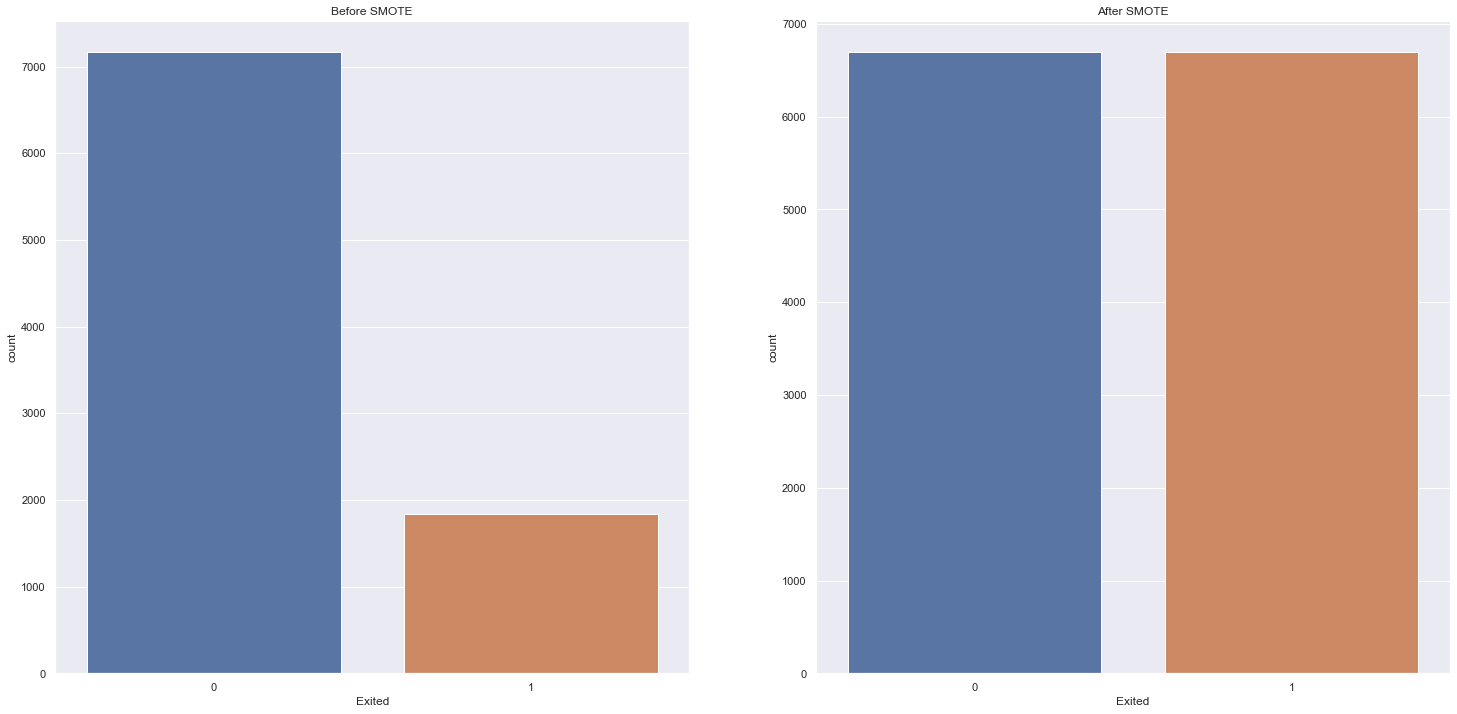

In [11]:
# plots before and after SMOTE
plt.subplot(1,2,1)
sns.countplot(x=yTrain);
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=yBalanced);
plt.title("After SMOTE")

# MODELS
---
- Lightgbm Classifier
- XGBoost Classifier

In [14]:
# spliting into train and valid
XBalancedTrain, XBalancedValid, yBalancedTrain, yBalancedValid = train_test_split(XBalanced, yBalanced, test_size=0.2, stratify=yBalanced)

## Lightgbm Classifier

In [20]:
modelName = 'Lightgbm Classifier'

params = [0.016490254525097375, #lr
        9, #max_depth
        9, #min_child_samples
        0.6502182010234373, #subsample
        0.6866210554187129, #colsample_bytree
        1069] #n_estimetors

lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]


model = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                           min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree,
                           bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', n_jobs=-1)


#Model
model.fit(XBalancedTrain, yBalancedTrain)

# Prediction
yhatLGBM = model.predict(XBalancedValid)

# Prediction Proba
yhatProbaLGBM = model.predict_proba(XBalancedValid)[:,1]

#Performance
modelResultLGBM = mlScores(modelName, yBalancedValid, yhatLGBM, yhatProbaLGBM)

modelResultLGBM

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.89671,0.87528,0.885865,0.774459,0.962609,0.956221


## XGBoost Classifier

In [21]:
modelName = 'XGBoost Classifier'

params = [0.0699516121742407, #lr
        9, #max_depth
        6, #min_child_weight
        0.8287804603180822, #subsample
        0.6477856515609233, #colsample_bytree
        370, #n_estimetors
        0.06057685654330215] #gamma

lr = params[0]
max_depth = params[1]
min_child_weight = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]
gamma = params[6]


model = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                       min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree,
                       bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', gamma=gamma, n_jobs=-1)


#Model
model.fit(XBalancedTrain, yBalancedTrain)

# Prediction
yhatXGB = model.predict(XBalancedValid)

# Prediction Proba
yhatProbaXGB = model.predict_proba(XBalancedValid)[:,1]

#Performance
modelResultXGB = mlScores(modelName, yBalancedValid, yhatXGB, yhatProbaXGB)

modelResultXGB

[19:06:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,XGBoost Classifier,0.896739,0.862584,0.87933,0.763256,0.956225,0.94927


# Ensemble

In [22]:
pd.DataFrame({'XGB': yhatProbaXGB, 'LGBM': yhatProbaLGBM}).corr()

,XGB,LGBM
XGB,1.000000,0.979475
LGBM,0.979475,1.000000


In [26]:
p = (0.3*yhatProbaXGB + 0.7*yhatProbaLGBM)
print(f'ap: {average_precision_score(yBalancedValid,p)}, auc: {roc_auc_score(yBalancedValid, p)}')

ap: 0.9620128283209117, auc: 0.9559110524111213


- ap: 0.9610622880418789, auc: 0.9549846312246888 | 0.5 / 0.5
- ap: 0.9615843654971399, auc: 0.9555178393247666 | 0.4 / 0.6
- ap: 0.9620128283209117, auc: 0.9559110524111213 | 03 / 0.7

In [43]:
dfResultCompare = pd.DataFrame({'yBalancedValid': yBalancedValid, 'XGByhatXGB': yhatXGB, 'XGByhatProbaXGB': yhatProbaXGB, 'LGBMyhatLGBM': yhatLGBM, 'LGBMyhatProbaLGBM': yhatProbaLGBM, 'EnsembleProba': 0.3*yhatProbaXGB + 0.7*yhatProbaLGBM})

In [44]:
dfResultCompare.head()

,yBalancedValid,XGByhatXGB,XGByhatProbaXGB,LGBMyhatLGBM,LGBMyhatProbaLGBM,EnsembleProba
8391,1,1,0.986964,1,0.990604,0.989512
10421,1,1,0.934696,1,0.954038,0.948235
9957,1,1,0.972962,1,0.978481,0.976825
13373,1,1,0.841442,1,0.979297,0.937941
2113,0,0,0.037151,0,0.031727,0.033354


In [53]:
dfResultCompare['FinalResult'] = dfResultCompare['EnsembleProba'].apply(lambda row: 1 if row > 0.5 else 0)

In [54]:
dfResultCompare['CompareFinalResult'] = dfResultCompare.apply(lambda row: 1 if row['FinalResult'] != row['yBalancedValid'] else 0, axis=1)
dfResultCompare1 = dfResultCompare[dfResultCompare['CompareFinalResult'] == 1]

In [55]:
dfResultCompare1.shape

(302, 8)